# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN.
Particularly in this case based on VGG16

In [ ]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
import keras
import numpy as np
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [ ]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [ ]:
from PIL import Image

X_train = np.array([Image.fromarray(x).resize((48,48)) for x in X_train])

X_val = np.array([Image.fromarray(x).resize((48,48)) for x in X_val])

X_test = np.array([Image.fromarray(x).resize((48,48)) for x in X_test])


In [ ]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

In [ ]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [ ]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(base_model.input, pred)

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [ ]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [ ]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=EPOCHS,
                    verbose=1)


1328/1328 [==============================] - 20s 10ms/step - loss: 0.2846 - accuracy: 0.3827 - val_loss: 0.1982 - val_accuracy: 0.5835


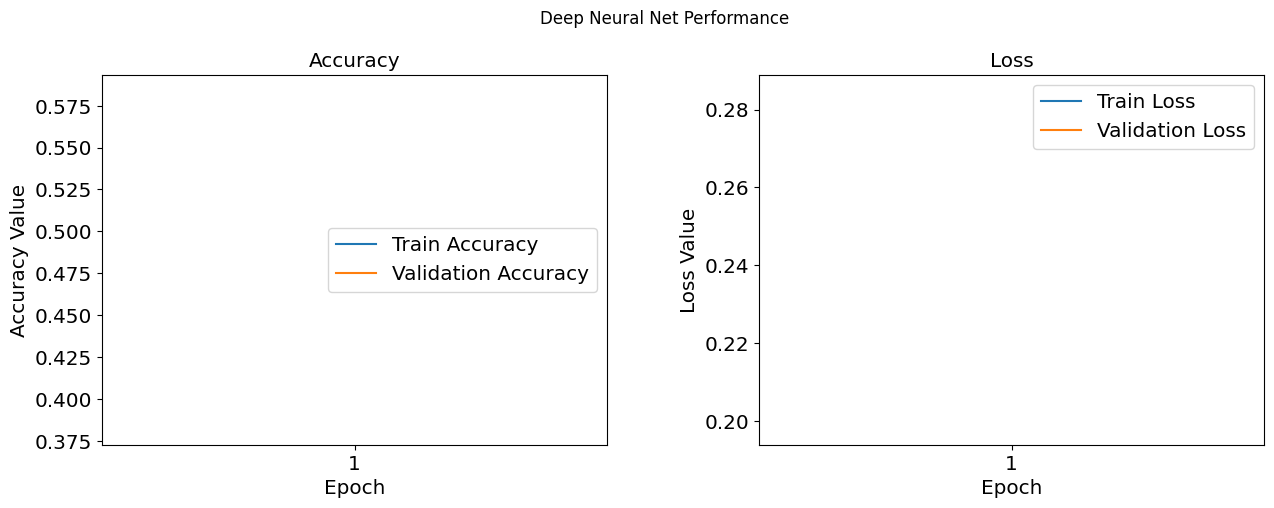

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 2s 7ms/step


In [ ]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [ ]:
get_metrics(true_labels=y_test,
                predicted_labels=predictions)

[0.5852, 0.582045087787842, 0.5852, 0.5791867600408477]

In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

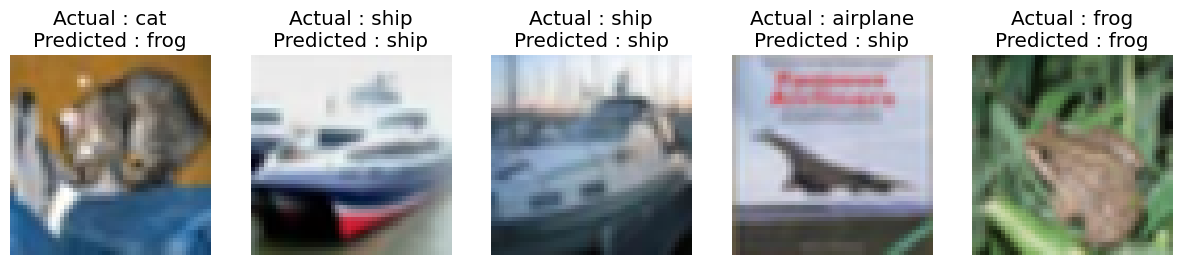

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    ax[i].imshow(X_test[i])
    ax[i].set_title("Actual : {}\nPredicted : {}".format(label_dict[y_test[i][0]], label_dict[predictions[i]]))
    ax[i].axis('off')
plt.show()


In [ ]:
# A bar plot comparing the accuracy, precision, recall and F1_Score of VGG-16 and three different pre-trained models of your choice from the list:  https://keras.io/api/applications/

# VGG-16
#train the model on resnet50, vgg16, mobilenet, xception
from keras.applications import resnet50, mobilenet, vgg19, vgg16

# write a loop to train the model on resnet50, vgg16, mobilenet, xception. just change the model name in my code

models = ['resnet50', 'mobilenet', 'vgg19','vgg16']
metrics = []
for model_name in models:
        if model_name == 'vgg16':
                base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
                last = base_model.get_layer('block5_pool').output
        elif model_name == 'vgg19':
                base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
                last = base_model.get_layer('block5_pool').output
        elif model_name == 'resnet50':
                base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
                last = base_model.get_layer('conv5_block3_out').output
        elif model_name == 'mobilenet':
                base_model = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
                last = base_model.get_layer('conv_pw_13_relu').output
        else:
                print('Model not found')
                break

        # Add classification layers on top of it
        x = GlobalAveragePooling2D()(last)
        x= BatchNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.6)(x)
        pred = Dense(NUM_CLASSES, activation='softmax')(x)
        model = keras.Model(base_model.input, pred)

        for layer in base_model.layers:
                layer.trainable = False

        model.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
                            metrics=['accuracy'])

        history = model.fit(train_generator,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_generator,
                                validation_steps=val_steps_per_epoch,
                                epochs=EPOCHS,
                                verbose=1)

        predictions = model.predict(X_test/255.)

        test_labels = list(y_test.squeeze())

        predictions = list(predictions.argmax(axis=1))


        #save the metrics in a list
        model_metrics = get_metrics(true_labels=test_labels, predicted_labels=predictions)
        metrics.append(model_metrics)

        print(metrics)














Epoch 1/40
1328/1328 [==============================] - 33s 21ms/step - loss: 0.3111 - accuracy: 0.2728 - val_loss: 0.2556 - val_accuracy: 0.4136
Epoch 2/40
1328/1328 [==============================] - 27s 21ms/step - loss: 0.2665 - accuracy: 0.3774 - val_loss: 0.2414 - val_accuracy: 0.4443
Epoch 3/40
1328/1328 [==============================] - 25s 19ms/step - loss: 0.2544 - accuracy: 0.4127 - val_loss: 0.2344 - val_accuracy: 0.4607
Epoch 4/40
1328/1328 [==============================] - 25s 19ms/step - loss: 0.2453 - accuracy: 0.4378 - val_loss: 0.2298 - val_accuracy: 0.4758
Epoch 5/40
1328/1328 [==============================] - 27s 20ms/step - loss: 0.2385 - accuracy: 0.4575 - val_loss: 0.2261 - val_accuracy: 0.4884
Epoch 6/40
1328/1328 [==============================] - 27s 20ms/step - loss: 0.2338 - accuracy: 0.4739 - val_loss: 0.2217 - val_accuracy: 0.4959
Epoch 7/40
1328/1328 [==============================] - 27s 20ms/step - loss: 0.2296 - accuracy: 0.4818 - val_loss: 0.2203 -

[[0.5623, 0.560648465842977, 0.5623, 0.559638629708826]]
Epoch 1/40
1328/1328 [==============================] - 19s 11ms/step - loss: 0.3497 - accuracy: 0.1401 - val_loss: 0.3172 - val_accuracy: 0.2194
Epoch 2/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3183 - accuracy: 0.1864 - val_loss: 0.3123 - val_accuracy: 0.2350
Epoch 3/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3140 - accuracy: 0.2004 - val_loss: 0.3098 - val_accuracy: 0.2317
Epoch 4/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3115 - accuracy: 0.2077 - val_loss: 0.3092 - val_accuracy: 0.2328
Epoch 5/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3097 - accuracy: 0.2155 - val_loss: 0.3098 - val_accuracy: 0.2374
Epoch 6/40
1328/1328 [==============================] - 13s 10ms/step - loss: 0.3091 - accuracy: 0.2169 - val_loss: 0.3086 - val_accuracy: 0.2374
Epoch 7/40
1328/1328 [==============================] - 14s 11ms/st

           Accuracy  Precision  Recall  F1 Score
resnet50     0.5623   0.560648  0.5623  0.559639
mobilenet    0.2372   0.268144  0.2372  0.233838
vgg19        0.6191   0.617497  0.6191  0.617279
vgg16        0.6473   0.647027  0.6473  0.646886


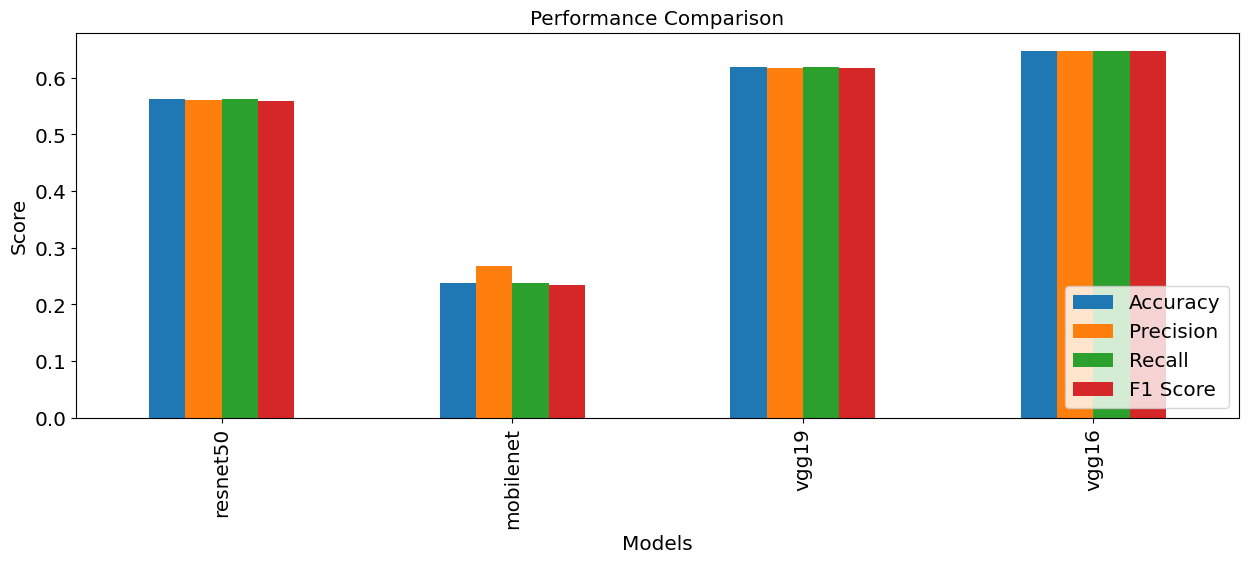

In [ ]:
#plot the metrics

metrics_df = pd.DataFrame(metrics, index=models, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(metrics_df)

metrics_df.plot(kind='bar', figsize=(15, 5))
plt.title('Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.show()
